Manufactured Solution experiment based on SAND2000 - 1444

Test based on heat flux example in SAND2000 - 1444 Section 3

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from sympy import symbols, sin, exp, sqrt, init_printing

In [4]:
from sympy import diff, simplify, Eq, lambdify

In [5]:
init_printing(use_unicode=True)

In [6]:
x, y, t = symbols('x y t')

# symbolic form

In [7]:
T0, R, t0, k0, rho0, Cp0 = symbols('T0 R t0 k0 rho0 Cp0')

In [8]:
T_sym = T0 * (1 + sin(x/R)**2 * sin(2*y/R)**2) * exp(t*(t0-t)/t0)

In [9]:
k_sym = k0 

In [10]:
rho_sym = rho0 

In [11]:
Cp_sym = Cp0 

In [12]:
g_sym = \
simplify(diff(Cp_sym * rho_sym * T_sym, t)
         - diff(k_sym * diff(T_sym, x), x) 
         - diff(k_sym * diff(T_sym, y), y))

In [13]:
g_sym

T0*(-Cp0*R**2*rho0*(2*t - t0)*(sin(x/R)**2*sin(2*y/R)**2 + 1) + 2*k0*t0*(5*sin(x/R)**2*sin(2*y/R)**2 - 4*sin(x/R)**2*cos(2*y/R)**2 - sin(2*y/R)**2*cos(x/R)**2))*exp(-t*(t - t0)/t0)/(R**2*t0)

# substitute coefficient values

In [14]:
subs = [(R, 3.33), (T0, 100), (Cp0, 1), (rho0, 0), (k0, 1), (t0, 1)]

In [15]:
g_sub, T_sub, k_sub, rho_sub, Cp_sub = [sym.subs(subs) for sym in (g_sym, T_sym, k_sym, rho_sym, Cp_sym)]

# generate FiPy lambda functions

In [16]:
g_fp, T_fp, k_fp, rho_fp, Cp_fp = [lambdify((x, y, t), sub, modules=fp.numerix) for sub in (g_sub, T_sub, k_sub, rho_sub, Cp_sub)]

# iterate over cell spacings

In [23]:
grid_spacing = 1. * 2.**fp.numerix.arange(0, -4, -1)

In [24]:
L2errors = []

In [25]:
LINFerrors = []

In [26]:
for dx in grid_spacing:
    mesh = fp.Grid2D(Lx=10., dx=dx, Ly=20., dy=dx)
    xx, yy = mesh.cellCenters[0], mesh.cellCenters[1]
    XX, YY = mesh.faceCenters[0], mesh.faceCenters[1]

    time = fp.Variable(name="$t$", value=0.)

    T = fp.CellVariable(mesh=mesh, name="$T$", hasOld=True)
    T.value = T_fp(xx, yy, 0.)*0.01
    T.constrain(T_fp(XX, YY, time), where=mesh.exteriorFaces)
    
    eq = (fp.DiffusionTerm(coeff=k_fp(XX, YY, time)) + g_fp(xx, yy, time)
          == fp.TransientTerm(coeff=rho_fp(xx, yy, time) * Cp_fp(xx, yy, time)))
    
    dt = 0.1
    
    while time.value <= 2.0:
        T.updateOld()
        eq.solve(var=T, dt=dt)
        time.value = time() + dt
        
    dT = T - T_fp(xx, yy, time - dt)
    
    L2errors.append(fp.numerix.L2norm(dT * mesh.cellVolumes) / fp.numerix.L2norm(mesh.cellVolumes))
    LINFerrors.append(fp.numerix.LINFnorm(dT))
    
    print dx, L2errors[-1], LINFerrors[-1]

1.0 0.503817557173 1.41167634586
0.5 0.120475931053 0.384879487428
0.25 0.0297926992543 0.0991875819048
0.125 0.00742806245874 0.0251614542358


In [27]:
from matplotlib import pyplot as plt

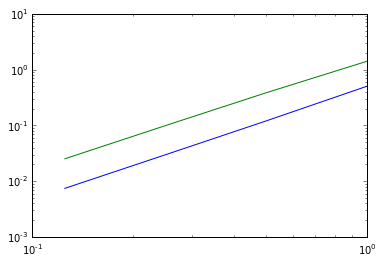

In [28]:
plt.loglog(grid_spacing, L2errors, grid_spacing, LINFerrors)

In [29]:
L2errors = fp.numerix.array(L2errors)

In [33]:
fp.numerix.log(L2errors[:-1] / L2errors[1:]) / fp.numerix.log(2.) - 2.

array([ 0.06415645,  0.01571421,  0.00390099])